In [2]:
import json
import numpy as np
import pandas as pd
from scipy.stats import friedmanchisquare, kruskal
from detectron2.structures import BoxMode
import scikit_posthocs as sp
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [3]:
# Function to calculate IoU
def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou


In [12]:
# Load the results and coco format paths for each class
class_paths = {
    'container': {
        'results': '../Satellite/output/lr001_BS4_container_test__aug_1/test_output_container_data/via_region_data_container_annotations/coco_instances_results.json',
        'coco_format': '../Satellite/output/lr001_BS4_container_test__aug_1/test_output_container_data/via_region_data_container_annotations/test_coco_format.json'
    },
    'refinery': {
        'results': '../Satellite/output/lr001_BS4_refinery_test__aug_1/test_output_refinery_data/via_region_data_refinery_annotations/coco_instances_results.json',
        'coco_format': '../Satellite/output/lr001_BS4_refinery_test__aug_1/test_output_refinery_data/via_region_data_refinery_annotations/test_coco_format.json'
    },
    'raw_material': {
        'results': '../Satellite/output/lr001_BS4_raw_test__aug_1/test_output_raw_data/via_region_data_raw_annotations/coco_instances_results.json',
        'coco_format': '../Satellite/output/lr001_BS4_raw_test__aug_1/test_output_raw_data/via_region_data_raw_annotations/test_coco_format.json'
    },
    'roll_on_roll_off': {
        'results': '../Satellite/output/lr001_BS4_roro_test__aug_1/test_output_roro_data/via_region_data_roro_annotations/coco_instances_results.json',
        'coco_format': '../Satellite/output/lr001_BS4_roro_test__aug_1/test_output_roro_data/via_region_data_roro_annotations/test_coco_format.json'
    },
    'warehouse': {
        'results': '../Satellite/output/lr001_BS4_warehouse_test__aug_3/test_output_warehouse_data/via_region_data_warehouse_annotations/coco_instances_results.json',
        'coco_format': '../Satellite/output/lr001_BS4_warehouse_test__aug_3/test_output_warehouse_data/via_region_data_warehouse_annotations/test_coco_format.json'
    },
    'oil_and_gas': {
        'results': '../Satellite/output/lr001_BS4_oil_gas_test__aug_1/test_output_oil_gas_data/via_region_data_oil_gas_annotations/coco_instances_results.json',
        'coco_format': '../Satellite/output/lr001_BS4_oil_gas_test__aug_1/test_output_oil_gas_data/via_region_data_oil_gas_annotations/test_coco_format.json'
    }
}

# ## Before data augmentation 
# class_paths = {
#     'container': {
#         'results': '../Satellite/output/lr001_BS4_container_test_13/val_output_container_data/via_region_data_container_annotations/coco_instances_results.json',
#         'coco_format': '../Satellite/output/lr001_BS4_container_test_13/val_output_container_data/via_region_data_container_annotations/train_coco_format.json'
#     },
#     'refinery': {
#         'results': '../Satellite/output/lr001_BS4_refinery_test_13/train_output_refinery_data/via_region_data_refinery_annotations/coco_instances_results.json',
#         'coco_format': '../Satellite/output/lr001_BS4_refinery_test_13/train_output_refinery_data/via_region_data_refinery_annotations/train_coco_format.json'
#     },
#     'raw_material': {
#         'results': '../Satellite/output/lr001_BS4_raw_test_13/val_output_raw_data/via_region_data_raw_annotations/coco_instances_results.json',
#         'coco_format': '../Satellite/output/lr001_BS4_raw_test_13/val_output_raw_data/via_region_data_raw_annotations/train_coco_format.json'
#     },
#     'roll_on_roll_off': {
#         'results': '../Satellite/output/lr001_BS4_roro_test_13/train_output_roro_data/via_region_data_roro_annotations/coco_instances_results.json',
#         'coco_format': '../Satellite/output/lr001_BS4_roro_test_13/train_output_roro_data/via_region_data_roro_annotations/train_coco_format.json'
#     },
#     'warehouse': {
#         'results': '../Satellite/output/lr001_BS4_warehouse_test_13/train_output_warehouse_data/via_region_data_warehouse_annotations/coco_instances_results.json',
#         'coco_format': '../Satellite/output/lr001_BS4_warehouse_test_13/train_output_warehouse_data/via_region_data_warehouse_annotations/train_coco_format.json'
#     },
#     'oil_and_gas': {
#         'results': '../Satellite/output/lr001_BS4_oil_gas_test_13/val_output_oil_gas_data/via_region_data_oil_gas_annotations/coco_instances_results.json',
#         'coco_format': '../Satellite/output/lr001_BS4_oil_gas_test_13/val_output_oil_gas_data/via_region_data_oil_gas_annotations/train_coco_format.json'
#     }
# }


In [13]:
# Initialize lists to hold IoU values for each class
class_ious = {key: [] for key in class_paths.keys()}

for class_name, paths in class_paths.items():
    # Load predictions
    with open(paths['results']) as f:
        predictions = json.load(f)

    # Load ground truth annotations
    with open(paths['coco_format']) as f:
        ground_truth = json.load(f)

    # Prepare DataFrames
    df_pred = pd.DataFrame(predictions)
    df_truth = pd.DataFrame(ground_truth['annotations'])
    df_images = pd.DataFrame(ground_truth['images'])

    # Merge DataFrames on image_id
    df_truth = pd.merge(df_truth, df_images, left_on='image_id', right_on='id')

    # Filter predictions by score threshold
    df_pred = df_pred[df_pred['score'] > 0.5]

    # Calculate IoUs and categorize them by class
    for _, pred_row in df_pred.iterrows():
        pred_bbox = pred_row['bbox']
        pred_bbox = BoxMode.convert(pred_bbox, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
        pred_class_id = int(pred_row['category_id'])
        
        matching_truth = df_truth[df_truth['image_id'] == pred_row['image_id']]
        for _, truth_row in matching_truth.iterrows():
            truth_bbox = truth_row['bbox']
            truth_bbox = BoxMode.convert(truth_bbox, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
            truth_class_id = int(truth_row['category_id'])
            
            if truth_class_id == pred_class_id:
                iou = calculate_iou(truth_bbox, pred_bbox)
                class_ious[class_name].append(iou)
                break

# Print the mean IoU per class
for class_name, ious in class_ious.items():
    mean_iou = np.mean(ious) if ious else 0  # Handle the case where ious might be empty
    print(f'Mean IoU for {class_name}: {mean_iou}')
    
# Print the lengths before padding
for class_name, ious in class_ious.items():
    print(f'Length of IoU list for {class_name}: {len(ious)}')



Mean IoU for container: 0.43218283162453974
Mean IoU for refinery: 0.3941760191669157
Mean IoU for raw_material: 0.29342428162975187
Mean IoU for roll_on_roll_off: 0.34358359683178485
Mean IoU for warehouse: 0.28681673113079015
Mean IoU for oil_and_gas: 0.36467853191591765
Length of IoU list for container: 75
Length of IoU list for refinery: 176
Length of IoU list for raw_material: 108
Length of IoU list for roll_on_roll_off: 25
Length of IoU list for warehouse: 59
Length of IoU list for oil_and_gas: 107


In [14]:
# Perform Kruskal-Wallis test without padding
kruskal_stat, kruskal_p = kruskal(*class_ious.values())
print(f'Kruskal-Wallis test statistic: {kruskal_stat}, p-value: {kruskal_p}')

Kruskal-Wallis test statistic: 13.382516119303313, p-value: 0.02004607938648663


In [15]:
# Prepare DataFrame for Dunn's test
df_errors = pd.DataFrame(padded_class_ious)
df_errors_melted = df_errors.melt(var_name='group', value_name='value')

# Perform post-hoc Dunn's test
dunn_results = sp.posthoc_dunn(df_errors_melted, val_col='value', group_col='group', p_adjust='bonferroni')
print("Dunn's post-hoc test results:")
print(dunn_results)

NameError: name 'padded_class_ious' is not defined

In [16]:
# Create boxplots for IoU distributions
plt.figure(figsize=(12, 8))
sns.boxplot(x='group', y='value', data=df_errors_melted)
plt.title('IoU Distributions by Class')
plt.xlabel('Class')
plt.ylabel('IoU')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

NameError: name 'df_errors_melted' is not defined

<Figure size 1200x800 with 0 Axes>

In [17]:
# Number of entries for each class
num_entries = {
    'container': 55,
    'refinery': 110,
    'raw_material': 72,
    'roll_on_roll_off': 27,
    'warehouse': 48,
    'oil_and_gas': 80
}



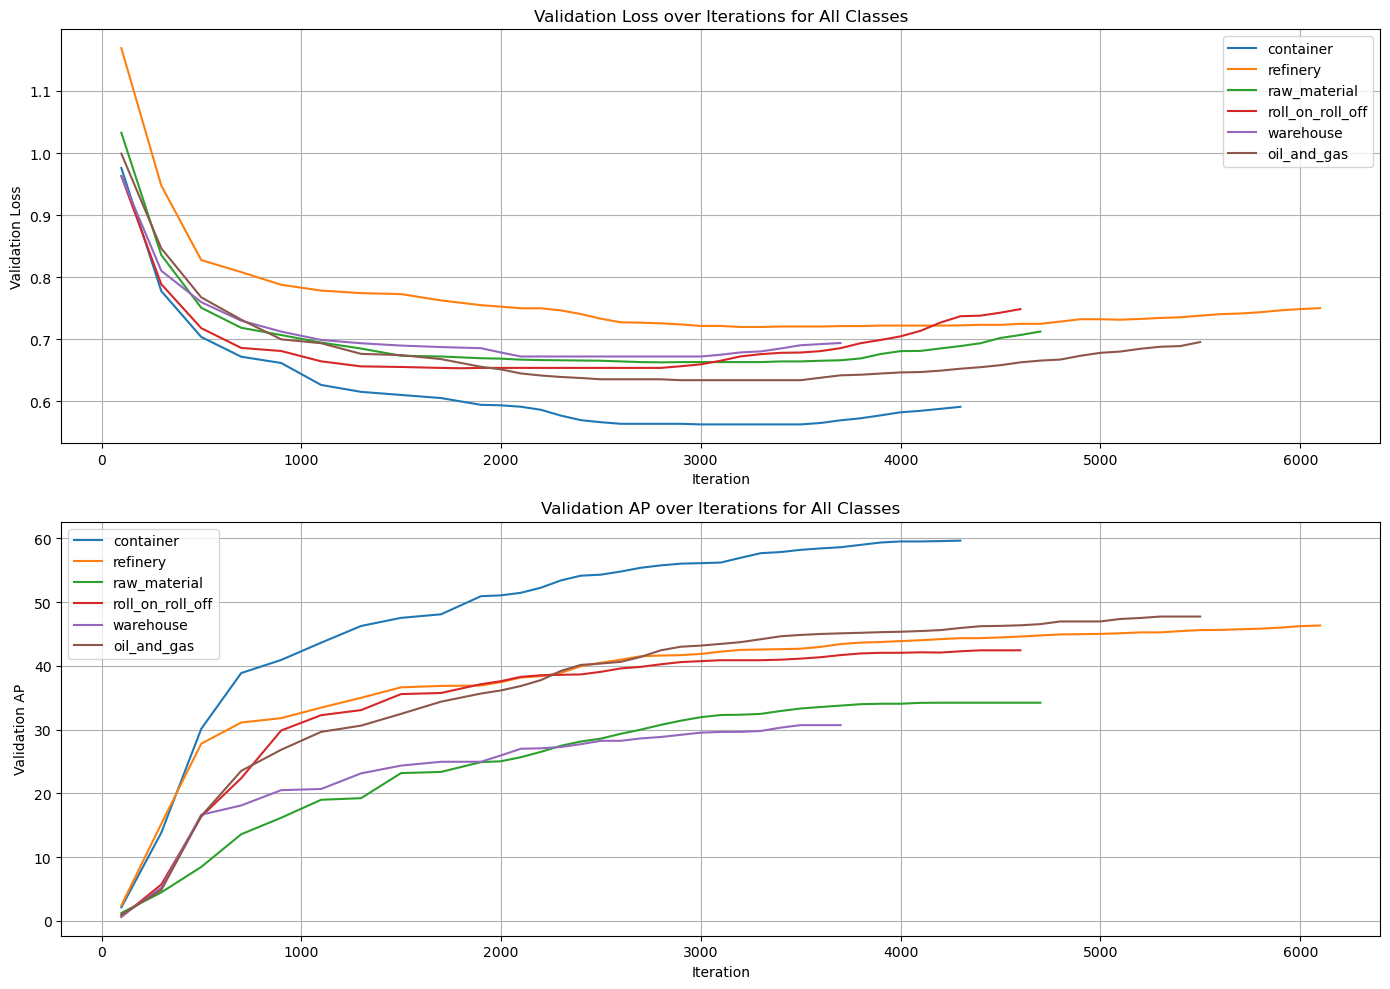

In [18]:
###Plot validation loss vs validation AP 
import json
import matplotlib.pyplot as plt

# Paths to the JSON metrics files for each class
class_paths = {
    'container': '../Satellite/output/lr001_BS4_container_test__aug_1/metrics.json',
    'refinery': '../Satellite/output/lr001_BS4_refinery_test__aug_1/metrics.json',
    'raw_material': '../Satellite/output/lr001_BS4_raw_test__aug_1/metrics.json',
    'roll_on_roll_off': '../Satellite/output/lr001_BS4_roro_test__aug_1/metrics.json',
    'warehouse': '../Satellite/output/lr001_BS4_warehouse_test__aug_3/metrics.json',
    'oil_and_gas': '../Satellite/output/lr001_BS4_oil_gas_test__aug_1/metrics.json'
}

# Initialize lists to hold metrics for each class
metrics = {key: {'validation_loss': [], 'validation_ap': [], 'iterations': []} for key in class_paths.keys()}

# Load the JSON data for each class
for class_name, path in class_paths.items():
    with open(path, 'r') as f:
        for line in f:
            try:
                entry = json.loads(line)
                if 'validation_loss' in entry and 'validation_ap' in entry:
                    metrics[class_name]['validation_loss'].append(entry['validation_loss'])
                    metrics[class_name]['validation_ap'].append(entry['validation_ap'])
                    metrics[class_name]['iterations'].append(entry['iteration'])
            except json.JSONDecodeError:
                continue

# Create a single figure with two subplots: one for validation loss and one for validation AP
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
for class_name, metric in metrics.items():
    plt.plot(metric['iterations'], metric['validation_loss'], label=class_name)
plt.xlabel('Iteration')
plt.ylabel('Validation Loss')
plt.title('Validation Loss over Iterations for All Classes')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
for class_name, metric in metrics.items():
    plt.plot(metric['iterations'], metric['validation_ap'], label=class_name)
plt.xlabel('Iteration')
plt.ylabel('Validation AP')
plt.title('Validation AP over Iterations for All Classes')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


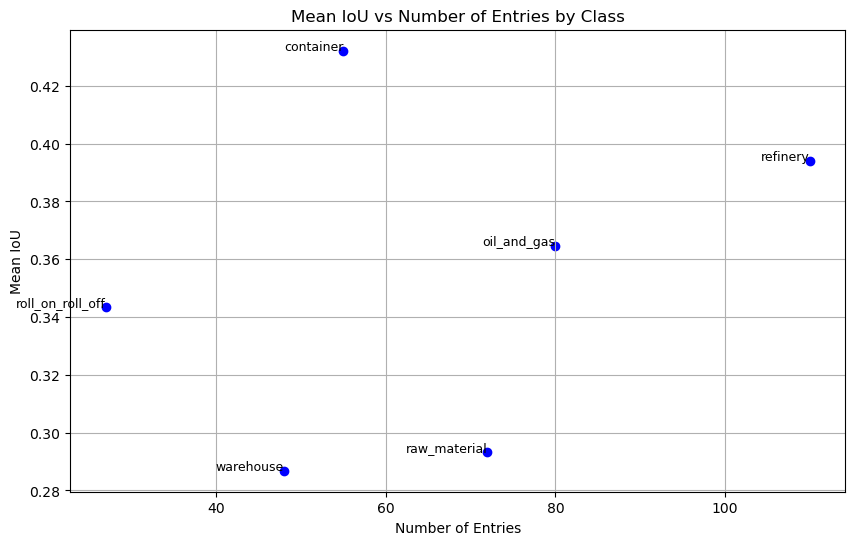

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Example data from previous code
num_entries = {
    'container': 55,
    'refinery': 110,
    'raw_material': 72,
    'roll_on_roll_off': 27,
    'warehouse': 48,
    'oil_and_gas': 80
}

# Calculate the mean IoU for each class
mean_ious = {class_name: np.mean(ious) if ious else 0 for class_name, ious in class_ious.items()}

# Prepare data for plotting
entries = [num_entries[class_name] for class_name in mean_ious.keys()]
ious = [mean_ious[class_name] for class_name in mean_ious.keys()]

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(entries, ious, color='blue')

# Add labels and title
for i, class_name in enumerate(mean_ious.keys()):
    plt.text(entries[i], ious[i], class_name, fontsize=9, ha='right')

plt.xlabel('Number of Entries')
plt.ylabel('Mean IoU')
plt.title('Mean IoU vs Number of Entries by Class')
plt.grid(True)
plt.show()
